# Интеллектуальный анализ данных, БИ

## НИУ ВШЭ, 2024-25 учебный год

# Семинар 17: Отбор признаков

In [ ]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


## Данные

Мы будем работать с данными из соревнования Home Credit Default Risk в котором требовалось предсказать вернет ли клиент кредит

https://www.kaggle.com/c/home-credit-default-risk

Загрузим данные и посмотрим на них

In [ ]:
application_train = pd.read_csv('application_train.csv')
application_train.shape

(307511, 122)

In [ ]:
application_train.sample(5)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
258867      399577       0         Cash loans           F            Y   
178116      306406       0         Cash loans           F            N   
150991      275023       0         Cash loans           M            Y   
117134      235834       0         Cash loans           F            N   
26504       130812       1         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
258867               Y             2          202500.0    592560.0   
178116               N             0          112500.0   1066320.0   
150991               N             0          135000.0    360000.0   
117134               Y             0           76500.0    436032.0   
26504                Y             0          121500.0     71955.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  \
258867      30384.0  ...                 0                0                0   
178116      38299.5  ...                 0                0                0   
150991      22023.0  ...                 0                0                0   
117134      16564.5  ...                 0                0                0   
26504        7137.0  ...                 0                0                0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
258867                0                        0.0                       0.0   
178116                0                        0.0                       0.0   
150991                0                        0.0                       0.0   
117134                0                        0.0                       0.0   
26504                 0                        0.0                       0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
258867                         0.0                        0.0   
178116                         0.0                        0.0   
150991                         0.0                        0.0   
117134                         0.0                        0.0   
26504                          0.0                        0.0   

        AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
258867                        0.0                         3.0  
178116                        0.0                         3.0  
150991                        1.0                         3.0  
117134                        0.0                         1.0  
26504                         0.0                         2.0  

[5 rows x 122 columns]

In [ ]:
application_train.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

Для удобства далее будем рассматриватьлишь 10% данных.


In [ ]:
from sklearn.model_selection import train_test_split

application, _ = train_test_split(application_train,
                                  train_size=0.1,
                                  random_state=27,
                                  stratify=application_train.TARGET #Для сохранения баланса классов
                                  )
application = application.sort_values('SK_ID_CURR').reset_index(drop=True)
application.TARGET.value_counts()

0    28269
1     2482
Name: TARGET, dtype: int64

In [ ]:
application.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100008       0         Cash loans           M            N   
2      100016       0         Cash loans           F            N   
3      100031       1         Cash loans           F            N   
4      100036       0         Cash loans           F            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               Y             0           99000.0    490495.5      27517.5   
2               Y             0           67500.0     80865.0       5881.5   
3               Y             0          112500.0    979992.0      27076.5   
4               Y             0          112500.0    512064.0      25033.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        0.0                       0.0   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        1.0   
3                         0.0                        0.0   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        1.0                         1.0  
2                        0.0                         0.0  
3                        2.0                         2.0  
4                        2.0                         5.0  

[5 rows x 122 columns]

application_train довольно большая таблица, дальше она нам не нужна, можно ее удалить и собрать мусор

In [ ]:
del application_train
gc.collect(); #Собираем мусор

Выделим числовые и нечисловые признаки

In [ ]:
categorical_list = []
numerical_list = []
for i in application.columns.tolist():
    if application[i].dtype=='object':
        categorical_list.append(i)
    else:
        numerical_list.append(i)
print('Number of categorical features:', len(categorical_list))
print('Number of numerical features:', len(numerical_list))

Number of categorical features: 16
Number of numerical features: 106


Посмотрим на наличие пропущенных значений

In [ ]:
application.isnull().sum()

SK_ID_CURR                       0
TARGET                           0
NAME_CONTRACT_TYPE               0
CODE_GENDER                      0
FLAG_OWN_CAR                     0
                              ... 
AMT_REQ_CREDIT_BUREAU_DAY     4158
AMT_REQ_CREDIT_BUREAU_WEEK    4158
AMT_REQ_CREDIT_BUREAU_MON     4158
AMT_REQ_CREDIT_BUREAU_QRT     4158
AMT_REQ_CREDIT_BUREAU_YEAR    4158
Length: 122, dtype: int64

Для замены пропущенных значений можно выспользоваться `SimpleImputer` из sklearn: данная модель заменяет пропущенные значения (`np.nan`) каким-то образом `strategy` (по умолчанию заменяет средним, но можно и медиану, самым частым значением или указанной в `fill_value` константой)

In [ ]:
from sklearn.impute import SimpleImputer
application[numerical_list] = SimpleImputer(missing_values=np.nan,
                                            strategy='median').fit_transform(application[numerical_list])

In [ ]:
application.isnull().sum()

SK_ID_CURR                    0
TARGET                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 122, dtype: int64

In [ ]:
application.isnull().sum().any()

True

Теперь все числовые данные не имеют пропусков, но некоторые категориальные - да. Разберемся с ними

In [ ]:
application = pd.get_dummies(application, drop_first=True)
print(application.shape)

(30751, 226)


In [ ]:
application.isnull().sum().any()

False

In [ ]:
application.head()

SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0    100002.0     1.0           0.0          202500.0    406597.5   
1    100008.0     0.0           0.0           99000.0    490495.5   
2    100016.0     0.0           0.0           67500.0     80865.0   
3    100031.0     1.0           0.0          112500.0    979992.0   
4    100036.0     0.0           0.0          112500.0    512064.0   

   AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0      24700.5         351000.0                    0.018801     -9461.0   
1      27517.5         454500.0                    0.035792    -16941.0   
2       5881.5          67500.0                    0.031329    -13439.0   
3      27076.5         702000.0                    0.018029    -18724.0   
4      25033.5         360000.0                    0.008575    -11144.0   

   DAYS_EMPLOYED  ...  FONDKAPREMONT_MODE_reg oper spec account  \
0         -637.0  ...                                         0   
1        -1588.0  ...                                         0   
2        -2717.0  ...                                         0   
3        -2628.0  ...                                         0   
4        -1104.0  ...                                         0   

   HOUSETYPE_MODE_specific housing  HOUSETYPE_MODE_terraced house  \
0                                0                              0   
1                                0                              0   
2                                0                              0   
3                                0                              0   
4                                0                              0   

   WALLSMATERIAL_MODE_Mixed  WALLSMATERIAL_MODE_Monolithic  \
0                         0                              0   
1                         0                              0   
2                         0                              0   
3                         0                              0   
4                         0                              0   

   WALLSMATERIAL_MODE_Others  WALLSMATERIAL_MODE_Panel  \
0                          0                         0   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          0                         0   

   WALLSMATERIAL_MODE_Stone, brick  WALLSMATERIAL_MODE_Wooden  \
0                                1                          0   
1                                0                          0   
2                                0                          0   
3                                0                          1   
4                                0                          0   

   EMERGENCYSTATE_MODE_Yes  
0                        0  
1                        0  
2                        0  
3                        1  
4                        0  

[5 rows x 226 columns]

In [ ]:
application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30751 entries, 0 to 30750
Columns: 226 entries, SK_ID_CURR to EMERGENCYSTATE_MODE_Yes
dtypes: float64(106), uint8(120)
memory usage: 28.4 MB


Теперь выделим таргет (TARGET) и удалим SK_ID_CURR (Вопрос: Почему удаляем данный признак?)

In [ ]:
X = application.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = application.TARGET
feature_name = X.columns.tolist()

In [ ]:
X.shape

(30751, 224)

Теперь есть 224 признака, будем пробовать выбрать лучшие

## Одномерные методы

Идея: оценить важность каждого признака по отдельности, выбрать самые важные признаки

In [ ]:
def feature_selector(X, y, score_function, n_features=100):
    importance_list = []
    feature_names = X.columns.to_numpy()
    # Считаем важность для каждого признака
    for i in feature_names:
        importance_list.append(score_function(X[i], y))
    # Заменяем np.nan на 0
    importance_list = [0 if np.isnan(i) else i for i in importance_list]
    # Выбрали названия признаков с наибольшей важностью
    best_features = feature_names[np.argsort(importance_list)[-n_features:]][::-1]

    return best_features

### Корреляция Пирсона

Идея: подсчитали корреляцию признака $x^j$ и таргета ($R(x^j, y)$), если корреляция большая по модулю, значит признак информативный


$$R(x, y) = \frac{\sum_{i=1}^n(x_i - \overline{x})(y_i - \overline{y})}{\sqrt{\sum_{i=1}^n(x_i - \overline{x})^2 \sum_{i=1}^n(y_i - \overline{y})^2}}$$



In [ ]:
def pearson_correlation_abs(x, y):
  return np.abs(np.corrcoef(x, y)[0, 1])

In [ ]:
cor_features = feature_selector(X, y, score_function=pearson_correlation_abs)
print(str(len(cor_features)), 'selected features')

100 selected features


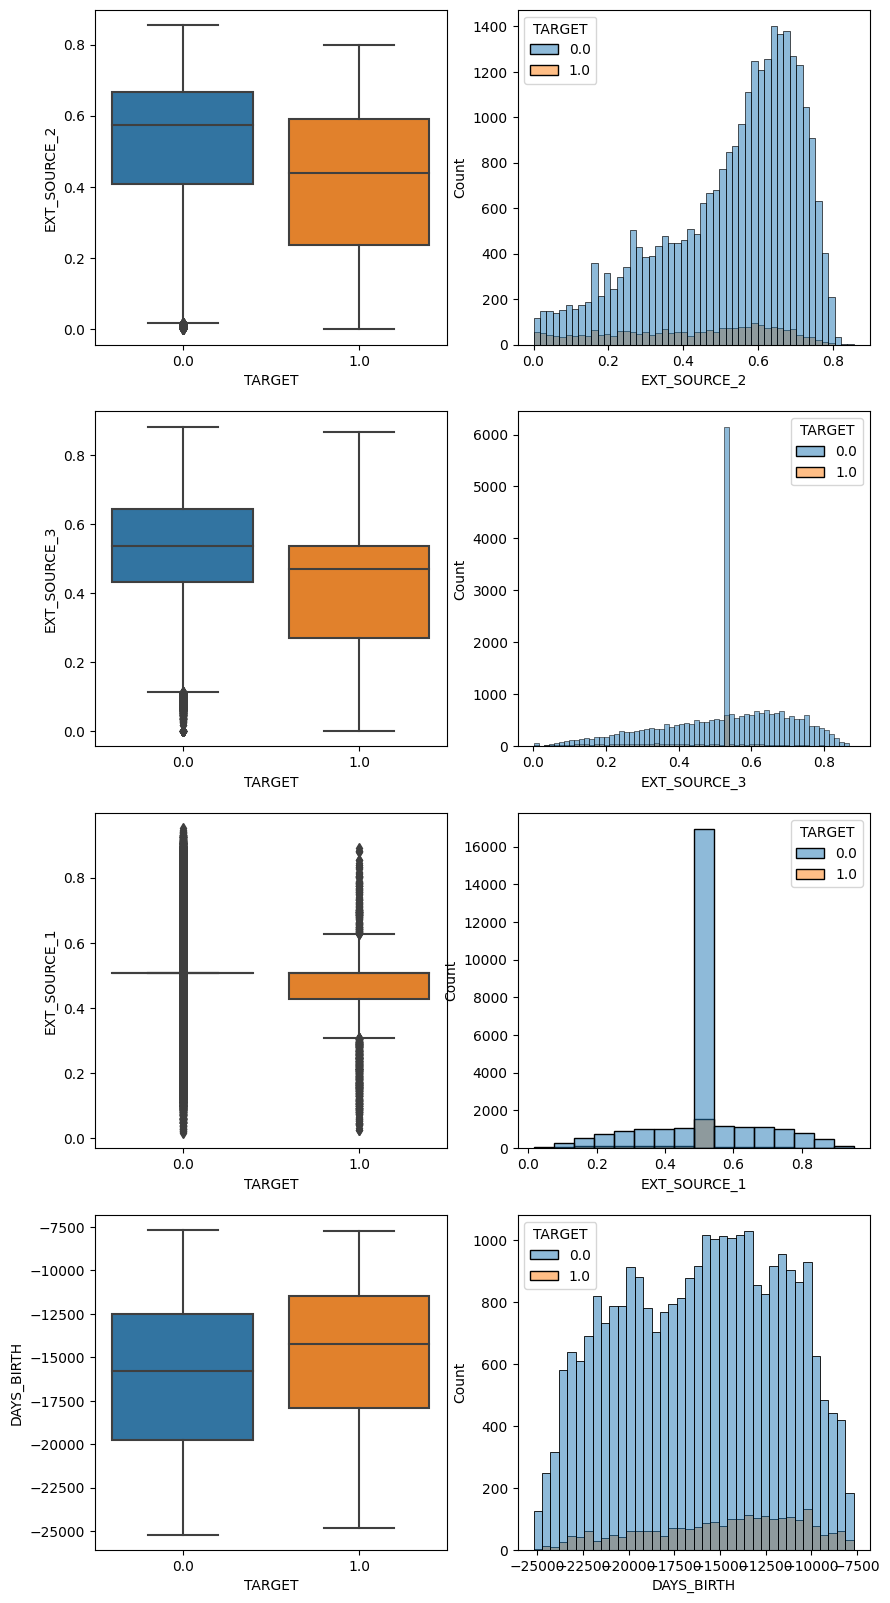

In [ ]:
fig, axs = plt.subplots(figsize=(10,20), nrows=4, ncols=2)

for i in range(4):
  sns.boxplot(y=X[cor_features[i]],
               x=y,
               ax=axs[i][0])
  sns.histplot(x=X[cor_features[i]],
               hue=y,
               ax=axs[i][1])

Проблема данного подхода: учитывается только линейная связь

### 2. T score

Идея: подсчитали t score признака $x^j$ на основе разделения по таргету таргета ($R(x^j, y)$), если t score большой, значит признак информативный


$$R(x, y) = \frac{|\mu_1 - \mu_0|}{\sqrt{\frac{\sigma_0^2}{n_0}+\frac{\sigma_1^2}{n_1}}}$$, где

$\mu_i, \sigma_i^2, n_i$ - это среднее, дисперсия и количество объектов для признака $x$ класса $i$ (0 или 1)

Данный метод используется для задачи бинарной классификации (для многоклассовой есть F score)

In [ ]:
def t_score(x, y):
  def calc_stats(x):
    return np.mean(x), np.var(x), len(x)

  mu0, s0, n0 = calc_stats(x[y == 0.0])
  mu1, s1, n1 = calc_stats(x[y == 1.0])
  return np.abs(mu1-mu0) / np.sqrt(s0/n0 + s1/n1)


In [ ]:
tscore_features = feature_selector(X, y, score_function=t_score)
print(str(len(tscore_features)), 'selected features')

100 selected features


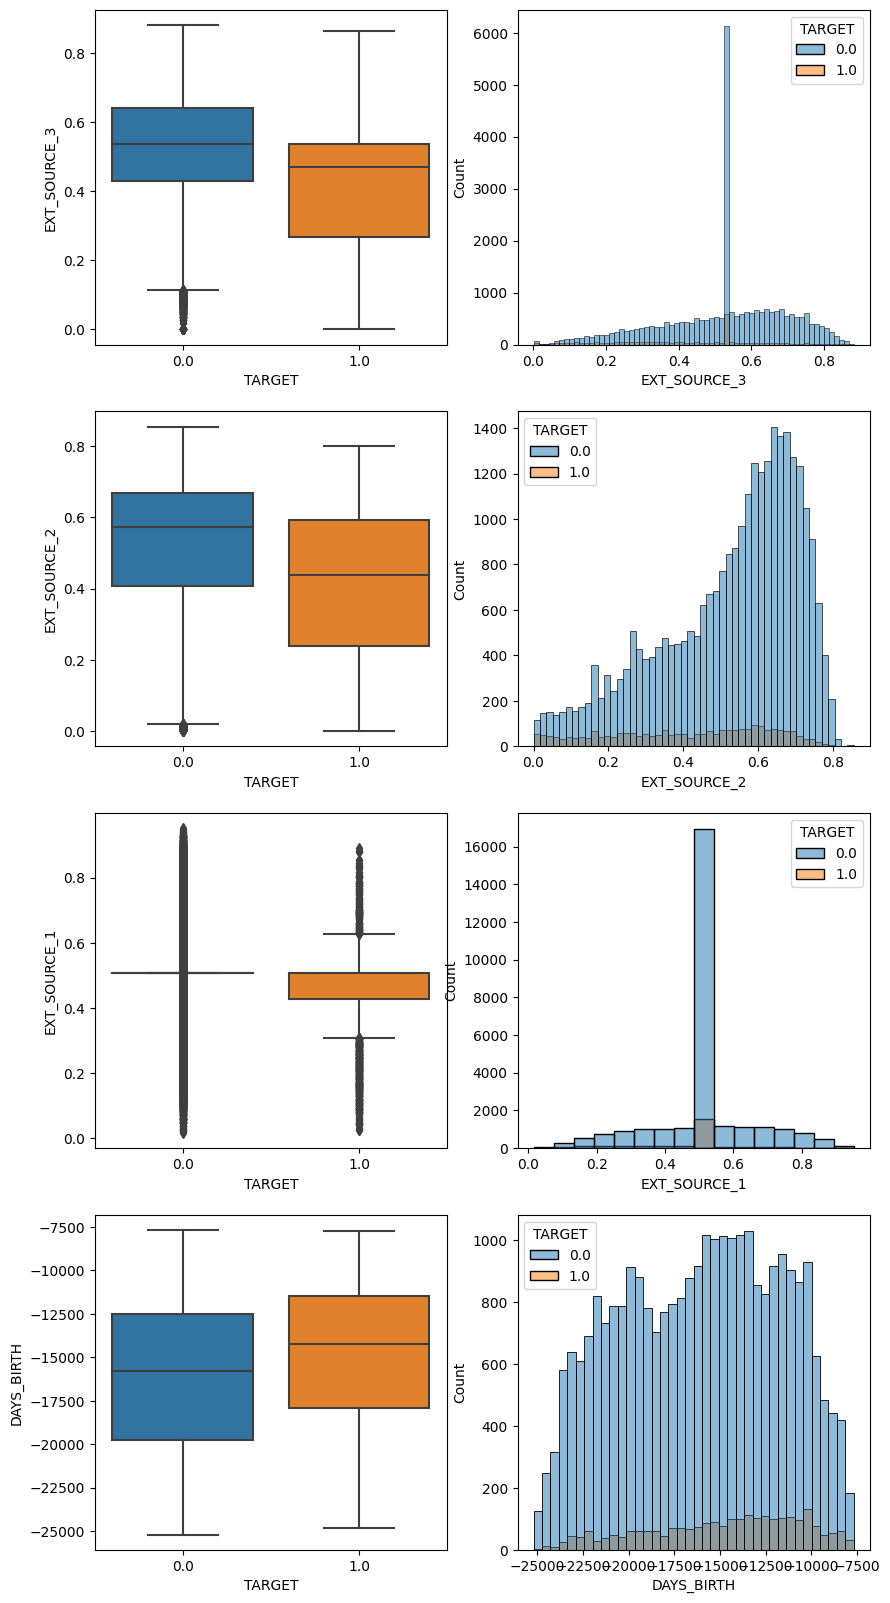

In [ ]:
fig, axs = plt.subplots(figsize=(10,20), nrows=4, ncols=2)

for i in range(4):
  sns.boxplot(y=X[tscore_features[i]],
               x=y,
               ax=axs[i][0])
  sns.histplot(x=X[tscore_features[i]],
               hue=y,
               ax=axs[i][1])

In [ ]:
set(cor_features) == set(tscore_features)

False

Основаня проблема одномерных методов - не работают, если целевая переменная зависит от совокупности признаков

## Методы обертки (Wrapper)

Идея:  оценить поднаборы признков, делая возможным обнаружения возможную взаимосвязь между совокупностью признаков

*RFE*(Recursive Feature Elimination) - обучается на начальном наборе признаков, и важность каждого признака получается либо через атрибут `coef_`, либо через атрибут `feature_importances_` модели, указанной в `estimator`.

Затем `step` наименее важных признаков удаляются. Эту процедура рекурсивно повторяется, пока в конечном итоге не будет достигнуто `n_features_to_select` признаков.

In [ ]:
from sklearn.preprocessing import StandardScaler
X_norm = StandardScaler().fit_transform(X)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=100, step=10, verbose=5)
rfe_selector.fit(X_norm, y)

Fitting estimator with 224 features.
Fitting estimator with 214 features.
Fitting estimator with 204 features.
Fitting estimator with 194 features.
Fitting estimator with 184 features.
Fitting estimator with 174 features.
Fitting estimator with 164 features.
Fitting estimator with 154 features.
Fitting estimator with 144 features.
Fitting estimator with 134 features.
Fitting estimator with 124 features.
Fitting estimator with 114 features.
Fitting estimator with 104 features.


RFE(estimator=LogisticRegression(), n_features_to_select=100, step=10,
    verbose=5)

In [ ]:
rfe_support = rfe_selector.get_support() #Получаем маску True/False для признаков
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

100 selected features


Основная проблема - вычислительно дорого

## Встроенные методы (Embeded)

Идея `SelectFromModel`: через `estimator` подсчитывается важность признаков. Если важность меньше порогового значения - признак убирается. Пороговое значение задается параметром `threshold` -можно задать числом или указать эвристику: “mean”, “median”, дополнительно можно добавить дробь (“0.1*mean”)


In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(estimator=LogisticRegression(penalty="l2"), threshold='1.25*median')
embeded_lr_selector.fit(X_norm, y)

SelectFromModel(estimator=LogisticRegression(), threshold='1.25*median')

In [ ]:
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

98 selected features


### Random Forest

Для некоторых моделей важность признаков - это атрибут `coef_` (Вопрос: можете привести примеры?), но у леса такого атрибута нет (Вопрос: почему?)


У леса есть атрибут `feature_importances_` - важность признака подсчитывается как нормализованная сумма уменьшений критерия по всем деревьям, по всем вершинам, где было разбиение по данному признаку.

Уменьшение критерия = $H(X_m) - \frac{|X_l|}{|X_m|} H(X_l) - \frac{|X_r|}{|X_m|} H(X_r)$



In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X, y)

RandomForestClassifier()

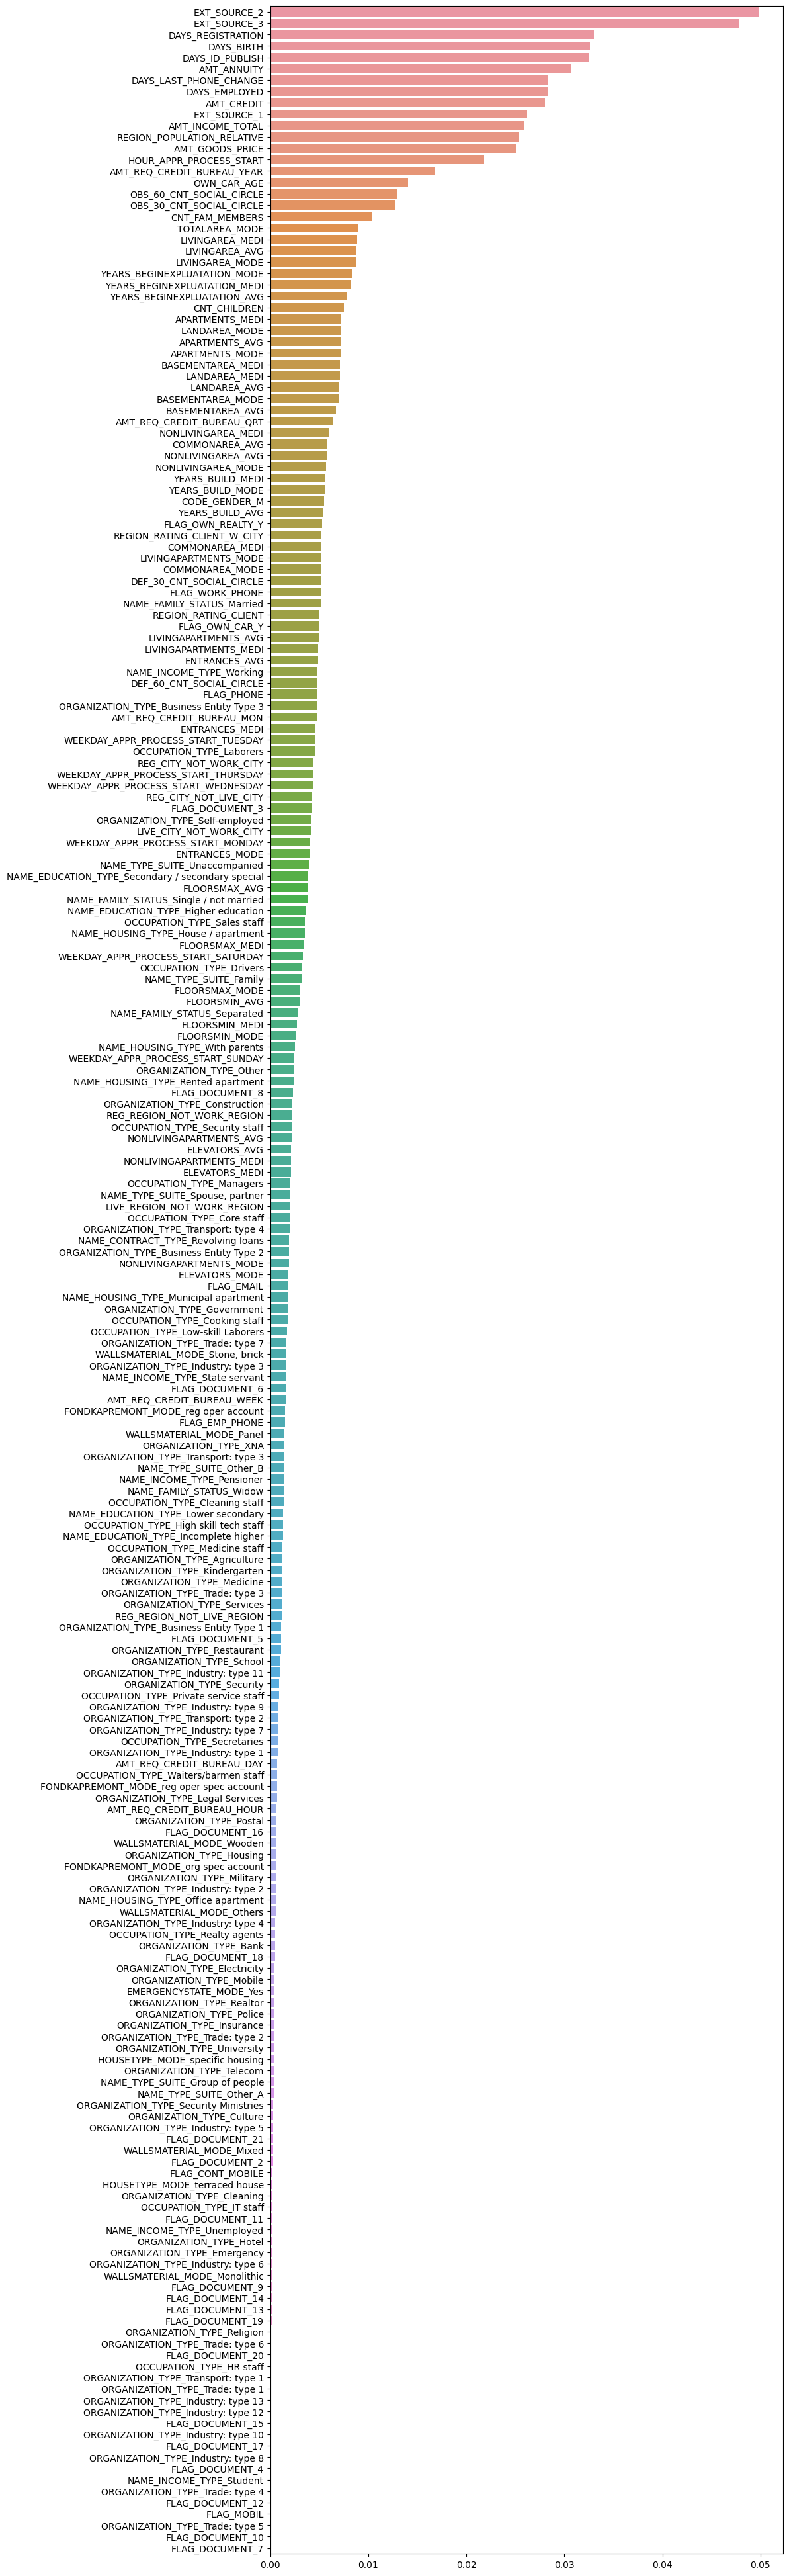

In [ ]:
plot = sns.barplot(y=feature_name,
                   x=clf.feature_importances_,
                   order=np.array(feature_name)[np.argsort(clf.feature_importances_)][::-1]
                   )
plot.figure.set_size_inches(10, 50)

Применим `SelectFromModel` к `RandomForestClassifier`

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100),
                                      threshold='1.25*median')
embeded_rf_selector.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(), threshold='1.25*median')

In [ ]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

98 selected features


### LGBMClassifier

`SelectFromModel` можно использовать не только с моделями из sklearn, например, можно использовать `LGBMClassifier` (у него тоже есть `feature_importances_`)

In [ ]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier
import re
X_renamed = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

lgbc=LGBMClassifier(n_estimators=500,
                    learning_rate=0.05,
                    num_leaves=32,
                    colsample_bytree=0.2,
                    reg_alpha=3,
                    reg_lambda=1,
                    min_split_gain=0.01,
                    min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, threshold='1.25*median')
embeded_lgb_selector.fit(X_renamed, y)

SelectFromModel(estimator=LGBMClassifier(colsample_bytree=0.2,
                                         learning_rate=0.05,
                                         min_child_weight=40,
                                         min_split_gain=0.01, n_estimators=500,
                                         num_leaves=32, reg_alpha=3,
                                         reg_lambda=1),
                threshold='1.25*median')

In [ ]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

108 selected features
